In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(X_train_full,y_train_full),(X_test,y_test) = keras.datasets.mnist.load_data()

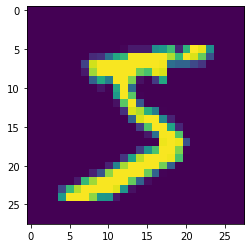

In [3]:
plt.imshow(X_train_full[0])

In [4]:
X_train_full.shape

(60000, 28, 28)

<h3> DNN Summary </h3> 

A DNN trained with 5 hiddens layers, 1 Flatten input layer

In [5]:
model_dnn = keras.models.Sequential()
model_dnn.add(keras.layers.Flatten(input_shape = [28,28]))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_dnn.add(keras.layers.Dense(5, activation="softmax"))

In [6]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5

Preparing the MNIST Data. 

First we shall only train on 0 to 4 digit labels, as we will use the rest for transfer learning.

In [7]:
def Prepdata0to4(X,y):
        y_data = y[np.where((y == 0) | (y == 1) | (y == 2)|(y == 3)| (y == 4))[0]]
        X_data = X[np.where((y == 0) | (y == 1) | (y == 2)|(y == 3)| (y == 4))[0]]
        return (X_data,y_data)

In [8]:
(X_data_0to4,y_data_0to4_sparse) = Prepdata0to4(X_train_full,y_train_full)

In [9]:
y_data_0to4 = keras.utils.to_categorical(y_data_0to4_sparse)
X_data_train0to4 = X_data_0to4[:25000]
y_data_train0to4 = y_data_0to4[:25000]
X_data_valid0to4 = X_data_0to4[25000:]
y_data_valid0to4 = y_data_0to4[25000:]

In [10]:
y_data_train0to4

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [11]:
X_data_valid0to4.shape

(5596, 28, 28)

In [12]:

(X_data_test0to4,y_data_test0to4_sparse) = Prepdata0to4(X_test,y_test)
y_data_test0to4 = keras.utils.to_categorical(y_data_test0to4_sparse)

In [13]:
y_data_test0to4_sparse

array([2, 1, 0, ..., 2, 3, 4], dtype=uint8)

In [14]:
#beta_1 is the momentum for moving mean of gradient
#beta_2 is the momentum for moving mean of squared gradient
adamoptim = keras.optimizers.Adam(lr = 0.001,beta_1=0.9,beta_2=0.999)
#callbacks to use
#checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint("zerotofour.h5", save_best_only=True)
#early stopping callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [15]:
#metrics
accuracy = keras.metrics.CategoricalAccuracy(name = "categorical_accuracy")
precision = keras.metrics.Precision()
recall = keras.metrics.Recall()
aucscore = keras.metrics.AUC()

In [16]:
model_dnn.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim, 
                    metrics = [accuracy,precision,recall,aucscore])

In [17]:
X_data_train0to4.shape

(25000, 28, 28)

In [18]:
y_data_train0to4.shape

(25000, 5)

In [19]:
model_dnn_history1 = model_dnn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_cb,earlystopping_cb])

Epoch 1/40
782/782 [==============================] - 5s 4ms/step - loss: 5.2510 - categorical_accuracy: 0.8817 - precision: 0.8817 - recall: 0.8816 - auc: 0.9368 - val_loss: 0.3594 - val_categorical_accuracy: 0.9580 - val_precision: 0.9585 - val_recall: 0.9580 - val_auc: 0.9856
Epoch 2/40
782/782 [==============================] - 2s 2ms/step - loss: 0.2667 - categorical_accuracy: 0.9639 - precision: 0.9643 - recall: 0.9637 - auc: 0.9891 - val_loss: 0.2442 - val_categorical_accuracy: 0.9627 - val_precision: 0.9635 - val_recall: 0.9621 - val_auc: 0.9905
Epoch 3/40
782/782 [==============================] - 2s 2ms/step - loss: 0.1690 - categorical_accuracy: 0.9724 - precision: 0.9727 - recall: 0.9721 - auc: 0.9928 - val_loss: 0.1865 - val_categorical_accuracy: 0.9664 - val_precision: 0.9671 - val_recall: 0.9652 - val_auc: 0.9920
Epoch 4/40
782/782 [==============================] - 2s 2ms/step - loss: 0.1328 - categorical_accuracy: 0.9729 - precision: 0.9735 - recall: 0.9724 - auc: 0.99

In [20]:
#predicting on validation data, test data and making confusion matrices
y_pred_valid = np.argmax(model_dnn.predict(X_data_valid0to4),axis = 1)
y_pred_test = np.argmax(model_dnn.predict(X_data_test0to4),axis = 1)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,auc
confusion_matrix(y_data_0to4_sparse[25000:],y_pred_valid)

array([[1097,    0,    3,    0,    0],
       [   0, 1167,    1,    2,    5],
       [   4,    3, 1077,    6,    5],
       [   2,    0,   15, 1132,    2],
       [   1,    3,    2,    1, 1068]], dtype=int64)

In [22]:
 precision_score(y_data_0to4_sparse[25000:],y_pred_valid, average='weighted')

0.9901803407018425

In [23]:
recall_score(y_data_0to4_sparse[25000:],y_pred_valid, average='weighted')

0.9901715511079342

In [24]:
#on test data
confusion_matrix(y_data_test0to4_sparse,y_pred_test)

array([[ 977,    0,    0,    3,    0],
       [   1, 1126,    3,    2,    3],
       [   5,    2, 1017,    2,    6],
       [   0,    0,    4, 1005,    1],
       [   2,    0,    3,    1,  976]], dtype=int64)

In [25]:
 precision_score(y_data_test0to4_sparse,y_pred_test, average='weighted')

0.9926140829447524

In [26]:
recall_score(y_data_test0to4_sparse,y_pred_test, average='weighted')

0.9926055652850749

In [27]:
#learning curves for lr = 0.01, beta1 = 0.9, beta2 = 0.9994
import pandas as pd
model_dnn_history1_df = pd.DataFrame(data = model_dnn_history1.history)
model_dnn_history1_df

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,1.714488,0.92904,0.929172,0.92880,0.966800,0.359379,0.958006,0.958520,0.958006,0.985630
1,0.245397,0.96488,0.965296,0.96464,0.990201,0.244235,0.962652,0.963493,0.962116,0.990539
2,0.164445,0.97244,0.972858,0.97208,0.993009,0.186471,0.966405,0.967055,0.965154,0.991950
3,0.119872,0.97516,0.975969,0.97472,0.995196,0.106354,0.976590,0.977289,0.976590,0.996429
4,0.080945,0.98212,0.982660,0.98152,0.997088,0.093580,0.976054,0.978819,0.974446,0.996731
5,0.070238,0.98284,0.983895,0.98236,0.997618,0.080642,0.980700,0.981389,0.979986,0.996982
6,0.065008,0.98368,0.984811,0.98296,0.998049,0.075044,0.985525,0.986051,0.985347,0.997186
7,0.061378,0.98516,0.985902,0.98464,0.998044,0.071085,0.981237,0.983163,0.980879,0.997844
8,0.055906,0.98592,0.987133,0.98508,0.998349,0.089357,0.977127,0.979889,0.975161,0.996801
9,0.040297,0.98884,0.989903,0.98828,0.998952,0.062814,0.984989,0.986392,0.984453,0.997251


In [45]:
#number of layers is fixed, only thing being changed is learning rate, beta1, beta2
def validating_dnn_model_0to4(lr = 0.001, beta1 = 0.9, beta2 = 0.999):
    #set for only 5 hidden layers
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28,28]))
    for i in range(5):
        model.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
    model.add(keras.layers.Dense(5, activation="softmax"))
    optim = keras.optimizers.Adam(lr = lr,beta_1=beta1,beta_2=beta2)
    accuracy = keras.metrics.CategoricalAccuracy(name = "categorical_accuracy")
    precision = keras.metrics.Precision()
    recall = keras.metrics.Recall()
    aucscore = keras.metrics.AUC()
    model.compile(loss = "categorical_crossentropy",
                    optimizer = optim, metrics = [accuracy,precision,recall,aucscore])
    return model

In [46]:
keras_dnn_model_0to4 = keras.wrappers.scikit_learn.KerasRegressor(validating_dnn_model_0to4)

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint("zerotofour.h5", save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

In [49]:
""" scoring_dnn = {
    "Precision" : make_scorer(precision),
    "Accuracy" : make_scorer(accuracy), 
    "Recall" : make_scorer(recall), 
    "AUC" : make_scorer(aucscore)
} """

param_grid_dnn_0to4 = {
    'lr' : (0.0005,0.001, 0.005, 0.01, 0.05, 0.1),
    'beta1' : (0.4,0.5,0.6,0.7,0.8),
    'beta2' : (0.6,0.7,0.8,0.9,0.999)
}

In [54]:
rnd_search_dnn = RandomizedSearchCV(estimator = keras_dnn_model_0to4, param_distributions = param_grid_dnn_0to4, verbose = 2, return_train_score = True, n_iter = 10, random_state = 42)

In [55]:
rnd_search_dnn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [earlystopping])

0.0000e+00 - val_recall_48: 0.0000e+00 - val_auc_48: 0.4961
Epoch 2/40
625/625 [==============================] - 2s 3ms/step - loss: 2.2740 - categorical_accuracy: 0.2055 - precision_48: 0.2045 - recall_48: 0.1036 - auc_48: 0.5041 - val_loss: 3.8227 - val_categorical_accuracy: 0.2057 - val_precision_48: 0.2057 - val_recall_48: 0.2057 - val_auc_48: 0.5052
Epoch 3/40
625/625 [==============================] - 3s 4ms/step - loss: 2.3292 - categorical_accuracy: 0.1993 - precision_48: 0.1999 - recall_48: 0.1145 - auc_48: 0.4995 - val_loss: 2.3477 - val_categorical_accuracy: 0.1957 - val_precision_48: 0.0000e+00 - val_recall_48: 0.0000e+00 - val_auc_48: 0.4995
Epoch 4/40
625/625 [==============================] - 2s 4ms/step - loss: 2.3127 - categorical_accuracy: 0.2024 - precision_48: 0.2005 - recall_48: 0.1134 - auc_48: 0.4971 - val_loss: 2.6131 - val_categorical_accuracy: 0.1957 - val_precision_48: 0.1957 - val_recall_48: 0.1957 - val_auc_48: 0.4939
Epoch 5/40
625/625 [==================

RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001493DB2E6D0>,
                   param_distributions={'beta1': (0.4, 0.5, 0.6, 0.7, 0.8),
                                        'beta2': (0.6, 0.7, 0.8, 0.9, 0.999),
                                        'lr': (0.0005, 0.001, 0.005, 0.01, 0.05,
                                               0.1)},
                   random_state=42, return_train_score=True, verbose=2)

In [83]:
 rnd_search_dnn.best_params_

{'lr': 0.001, 'beta2': 0.8, 'beta1': 0.6}

In [57]:
rnd_search_dnn.cv_results_

{'mean_fit_time': array([33.5206068 , 38.82044511, 32.86572871, 39.16927543, 31.75042915,
        33.96219087, 34.39076424, 25.77894049, 25.12856379, 42.26812019]),
 'std_fit_time': array([ 2.28353864,  5.46877311,  3.03540755,  2.7713266 ,  6.71178717,
         4.4722649 ,  9.68454947,  2.63433131,  1.40129335, 14.40459678]),
 'mean_score_time': array([0.31130266, 0.37521024, 0.35848684, 0.35290933, 0.36389451,
        0.37175903, 0.37860985, 0.43646936, 0.43322048, 0.33649211]),
 'std_score_time': array([0.01324068, 0.06313971, 0.01543878, 0.00668909, 0.01490505,
        0.01172453, 0.02474184, 0.09959751, 0.07308927, 0.00880491]),
 'param_lr': masked_array(data=[0.001, 0.0005, 0.05, 0.0005, 0.05, 0.001, 0.05, 0.01,
                    0.005, 0.05],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_beta2': masked_array(data=[0.8, 0.9, 0.999, 0.9, 0.8, 0.6, 0.6, 0.9

In [59]:
#y_pred_valid = np.argmax(model_dnn.predict(X_data_valid0to4),axis = 1)
#y_pred_test = np.argmax(model_dnn.predict(X_data_test0to4),axis = 1)
y_pred_tuned = np.argmax(rnd_search_dnn.best_estimator_.predict(X_data_test0to4),axis = 1)

precision_score(y_data_test0to4_sparse,y_pred_tuned, average='weighted')

0.9859283525944148

In [60]:
recall_score(y_data_test0to4_sparse,y_pred_tuned, average='weighted')

0.9857949017318545

In [82]:
model_tuned = keras.models.Sequential()
model_tuned.add(keras.layers.Flatten(input_shape = [28,28]))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned.add(keras.layers.Dense(5, activation="softmax"))

In [84]:
adamoptim_tuned = keras.optimizers.Adam(lr = 0.001,beta_1=0.6,beta_2=0.8)
checkpoint_tuned = keras.callbacks.ModelCheckpoint('tuned0to4.h5',save_best_only=True)
earlystopping_tuned = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [85]:
model_tuned.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim_tuned, 
                    metrics = [accuracy,precision,recall,aucscore])

In [86]:
model_tuned_history = model_tuned.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_tuned,earlystopping_tuned])

Epoch 1/40
782/782 [==============================] - 5s 4ms/step - loss: 4.7698 - categorical_accuracy: 0.9309 - precision: 0.9316 - recall: 0.9305 - auc: 0.9651 - val_loss: 0.7091 - val_categorical_accuracy: 0.9476 - val_precision: 0.9478 - val_recall: 0.9476 - val_auc: 0.9771
Epoch 2/40
782/782 [==============================] - 2s 3ms/step - loss: 0.4955 - categorical_accuracy: 0.9587 - precision: 0.9593 - recall: 0.9587 - auc: 0.9844 - val_loss: 0.2222 - val_categorical_accuracy: 0.9727 - val_precision: 0.9732 - val_recall: 0.9721 - val_auc: 0.9920
Epoch 3/40
782/782 [==============================] - 2s 3ms/step - loss: 0.2327 - categorical_accuracy: 0.9711 - precision: 0.9716 - recall: 0.9707 - auc: 0.9907 - val_loss: 0.1240 - val_categorical_accuracy: 0.9798 - val_precision: 0.9812 - val_recall: 0.9796 - val_auc: 0.9945
Epoch 4/40
782/782 [==============================] - 2s 3ms/step - loss: 0.1658 - categorical_accuracy: 0.9756 - precision: 0.9771 - recall: 0.9754 - auc: 0.99

In [100]:
y_pred_tuned_final_test = np.argmax(model_tuned.predict(X_data_test0to4),axis = 1)

precision_score(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_final_test, average='weighted')

0.9757561301443652

In [99]:
y_data_test0to4

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [79]:
final_model = keras.models.load_model('tuned0to4.h5')

In [92]:
#learning curve for the tuned model
history_tuned = pd.DataFrame(model_tuned_history.history)
history_tuned

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,1.909131,0.934991,0.935464,0.93473,0.968468,0.709079,0.947641,0.947811,0.947641,0.977135
1,0.416629,0.960480,0.961130,0.96040,0.986072,0.222192,0.972659,0.973166,0.972123,0.991952
2,0.218056,0.972280,0.972736,0.97188,0.991377,0.123965,0.979807,0.981206,0.979628,0.994454
3,0.177277,0.976680,0.977805,0.97628,0.993718,0.341116,0.963545,0.964222,0.963188,0.987608
4,0.152925,0.980160,0.980742,0.97980,0.994395,0.222671,0.978199,0.978880,0.977305,0.992952
5,0.126052,0.981360,0.982333,0.98084,0.995578,0.181065,0.982487,0.982657,0.982130,0.993550
6,0.133875,0.983840,0.984543,0.98344,0.996078,0.187319,0.981237,0.982287,0.981058,0.994316
7,0.105937,0.987200,0.987827,0.98680,0.996429,0.175938,0.984453,0.984805,0.984453,0.995291
8,0.109494,0.987600,0.988070,0.98724,0.996640,0.191036,0.985525,0.986576,0.984989,0.995870
9,0.094083,0.988320,0.988870,0.98796,0.997091,0.222941,0.982309,0.983178,0.981773,0.994376


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

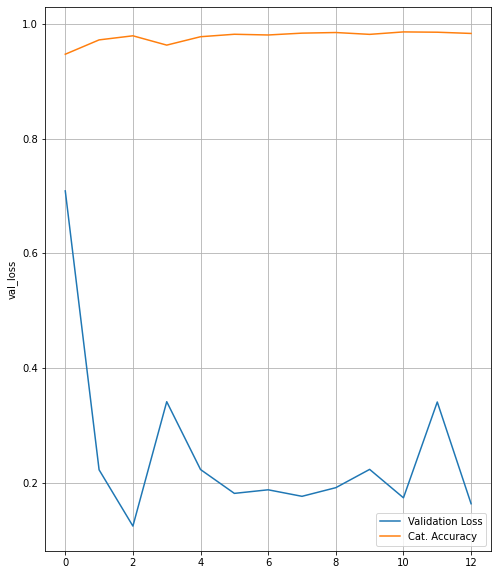

In [96]:
fig,ax_tuned = plt.subplots(1,1,figsize = (8,10))
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_loss"], label = "Validation Loss", ax = ax_tuned)
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_categorical_accuracy"], label = "Cat. Accuracy", ax = ax_tuned)
ax_tuned.legend()
ax_tuned.grid()

In [105]:
#adding batch Normalization layer to the above model
#Batch Normalization allows us to train with higher learning rates 
model_tuned_bn = keras.models.Sequential()
model_tuned_bn.add(keras.layers.Flatten(input_shape = [28,28]))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.BatchNormalization())
model_tuned_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer="he_normal"))
model_tuned_bn.add(keras.layers.Dense(5, activation="softmax"))

In [109]:
adamoptim_tuned_bn = keras.optimizers.Adam(lr = 0.001,beta_1=0.6,beta_2=0.8)
checkpoint_tuned_bn = keras.callbacks.ModelCheckpoint('tuned0to4bn.h5',save_best_only=True)
earlystopping_tuned_bn = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

model_tuned_bn.compile(loss = "categorical_crossentropy",
                    optimizer = adamoptim_tuned_bn, 
                    metrics = [accuracy,precision,recall,aucscore])

In [110]:
model_tuned_bn.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_54 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
dense_324 (Dense)            (None, 100)               78500     
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
_________________________________________________________________
dense_325 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)               400       
_________________________________________________________________
dense_326 (Dense)            (None, 100)             

In [111]:
model_tuned_bn_history = model_tuned_bn.fit(X_data_train0to4,y_data_train0to4, epochs = 40, validation_data=(X_data_valid0to4,y_data_valid0to4), callbacks = [checkpoint_tuned_bn,earlystopping_tuned_bn])

Epoch 1/40
782/782 [==============================] - 8s 6ms/step - loss: 0.2457 - categorical_accuracy: 0.9559 - precision: 0.9634 - recall: 0.9505 - auc: 0.9944 - val_loss: 0.0908 - val_categorical_accuracy: 0.9834 - val_precision: 0.9841 - val_recall: 0.9823 - val_auc: 0.9977
Epoch 2/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0696 - categorical_accuracy: 0.9792 - precision: 0.9808 - recall: 0.9780 - auc: 0.9984 - val_loss: 0.0955 - val_categorical_accuracy: 0.9853 - val_precision: 0.9868 - val_recall: 0.9848 - val_auc: 0.9983
Epoch 3/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0513 - categorical_accuracy: 0.9850 - precision: 0.9855 - recall: 0.9840 - auc: 0.9985 - val_loss: 0.1126 - val_categorical_accuracy: 0.9855 - val_precision: 0.9868 - val_recall: 0.9852 - val_auc: 0.9979
Epoch 4/40
782/782 [==============================] - 3s 4ms/step - loss: 0.0447 - categorical_accuracy: 0.9866 - precision: 0.9874 - recall: 0.9859 - auc: 0.99

In [112]:
history_tuned_bn = pd.DataFrame(model_tuned_bn_history.history)
history_tuned_bn

,loss,categorical_accuracy,precision,recall,auc,val_loss,val_categorical_accuracy,val_precision,val_recall,val_auc
0,0.142007,0.961139,0.967037,0.956922,0.995719,0.090825,0.983381,0.984067,0.982309,0.997690
1,0.068778,0.979480,0.980829,0.978200,0.998359,0.095539,0.985347,0.986750,0.984811,0.998326
2,0.054438,0.983880,0.984534,0.982880,0.998583,0.112594,0.985525,0.986755,0.985168,0.997913
3,0.042441,0.987080,0.987625,0.986440,0.998951,0.172988,0.988027,0.988557,0.988027,0.997807
4,0.035750,0.989680,0.990033,0.989320,0.999014,0.154362,0.989814,0.989986,0.989278,0.997786
5,0.032059,0.990080,0.990394,0.989760,0.999249,0.185213,0.988206,0.988907,0.987670,0.997533
6,0.025314,0.992360,0.992835,0.992120,0.999273,0.218878,0.986598,0.987299,0.986240,0.997257
7,0.025843,0.992200,0.992238,0.992040,0.999282,0.384320,0.988206,0.988204,0.988027,0.997413
8,0.026116,0.992480,0.992717,0.992320,0.999220,0.244035,0.988742,0.988917,0.988563,0.997590
9,0.023435,0.993600,0.993639,0.993440,0.999289,0.218670,0.986419,0.986769,0.986240,0.997324


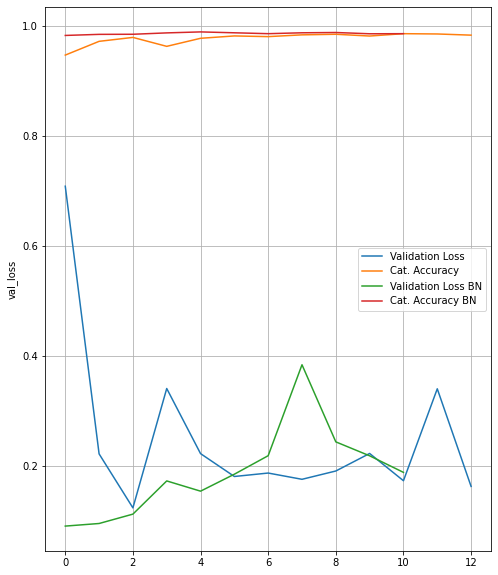

In [113]:
fig,ax_tuned = plt.subplots(1,1,figsize = (8,10))
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_loss"], label = "Validation Loss", ax = ax_tuned)
sns.lineplot(x = history_tuned.index.values.tolist(), y = history_tuned["val_categorical_accuracy"], label = "Cat. Accuracy", ax = ax_tuned)

sns.lineplot(x = history_tuned_bn.index.values.tolist(), y = history_tuned_bn["val_loss"], label = "Validation Loss BN", ax = ax_tuned)
sns.lineplot(x = history_tuned_bn.index.values.tolist(), y = history_tuned_bn["val_categorical_accuracy"], label = "Cat. Accuracy BN", ax = ax_tuned)

ax_tuned.legend()
ax_tuned.grid()

Batch Normalization makes it much faster to train your model. Using just one epoch, we have achieved the a higher accuracy that without BN

In [114]:
y_pred_tuned_bn_final_test = np.argmax(model_tuned_bn.predict(X_data_test0to4),axis = 1)

precision_score(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_bn_final_test, average='weighted')

0.9838833156508582

BN also gives better Precision 

In [115]:
confusion_matrix(np.argmax(y_data_test0to4,axis = 1),y_pred_tuned_bn_final_test)

array([[ 969,    2,    2,    2,    5],
       [   0, 1130,    2,    3,    0],
       [   1,   11, 1007,    8,    5],
       [   3,    4,   12,  991,    0],
       [   3,    0,   15,    5,  959]], dtype=int64)